In [1]:
import numpy as np
import random
import itertools
import pandas as pd
import multiprocessing
import math
import scipy.stats as ss
import seaborn as sns
import pickle
import re
import copy
from keras.utils import np_utils

from opyenxes.model.XLog import XLog
from opyenxes.data_in.XUniversalParser import XUniversalParser
from opyenxes.classification.XEventAttributeClassifier import XEventAttributeClassifier

from prefixspan import PrefixSpan

from tqdm import tqdm_notebook

Using TensorFlow backend.


In [2]:
### configuration
data_path = "../logs/bpic2011.xes"
traces_picklepath  = data_path.replace(".xes", "_raw_traces.pickled")
traces_dictionarypath = data_path.replace(".xes", "_dictionaries.pickled")
target_column = "concept:name"
categorical_feature_names = ["concept:name", "Section", "org:group"]
eosmarker = "<EOS>"
### configuration end

In [3]:
with open(data_path) as bpic_file:
    eventlog = XUniversalParser().parse(bpic_file)[0]

Unknown extension: http://www.xes-standard.org/meta_time.xesext
Unknown extension: http://www.xes-standard.org/meta_life.xesext
Unknown extension: http://www.xes-standard.org/meta_org.xesext
Unknown extension: http://www.xes-standard.org/meta_concept.xesext
Unknown extension: http://www.xes-standard.org/meta_3TU.xesext
Unknown extension: http://www.xes-standard.org/meta_general.xesext


In [10]:
ncores = multiprocessing.cpu_count()
ntraces = len(eventlog)

NameError: name 'eventlog' is not defined

## Extract data trace-wise from XES format

In [5]:
# collect all attributes
column_names = []

for event in eventlog[0]:
    for attribute in event.get_attributes():
        column_names.append(attribute)
        
column_names = set(column_names) # remove duplicates
column_names = list(column_names)

def create_dataframe_from_trace(t):
    df = pd.DataFrame(columns=column_names, index=range(0,len(t)))
    for event_idx, event in enumerate(t):
        event_attributes = event.get_attributes()
        df.iloc[event_idx]["__case_id"] = 0
        
        for attribute in event_attributes:
            df[attribute].values[event_idx] = event_attributes[attribute].get_value()
    
    return df

ppool = multiprocessing.Pool(ncores)
traces = []

for _ in tqdm_notebook(ppool.imap(create_dataframe_from_trace, eventlog),
                       total=len(eventlog),
                       unit="traces"):
        traces.append(_)

ppool.close()
del eventlog

In [6]:
pickle.dump(traces, open(traces_picklepath, "wb"))

In [4]:
traces = pickle.load(open(traces_picklepath, "rb"))

## Create complete feature set

In [5]:
for i in range(0,len(traces)):
    traces[i]["org:group"].fillna("NULL", inplace=True)
    traces[i]["Section"].fillna("NULL", inplace=True)

eventlog_df = pd.concat(traces, ignore_index=True)

for col in eventlog_df.columns:
    if eventlog_df[col].nunique() == 1:
        for t in traces:
            t.drop(columns=[col], inplace=True)
        eventlog_df.drop(columns=[col], inplace=True)
        print("Dropped column because it contains only a single value:", col)

Dropped column because it contains only a single value: lifecycle:transition


## Eliminate correlated or unimportant features

/home/felix.wolff2/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


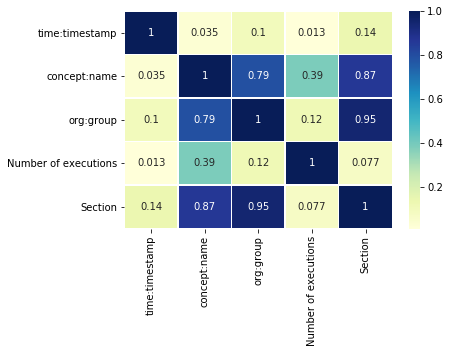

In [11]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
        https://stackoverflow.com/questions/46498455/categorical-features-correlation"""
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_df = pd.DataFrame(index=eventlog_df.columns,
                            columns=eventlog_df.columns,
                            dtype=np.float)

for col_a,col_b in itertools.product(eventlog_df.columns, repeat=2):   
    if col_a == col_b:
        cramers_v_df[col_a][col_b] = 1
    else:
        candidate = pd.crosstab(eventlog_df[col_a], eventlog_df[col_b]).as_matrix()
        cramers_v_df[col_a][col_b] = cramers_v(candidate)

sns.heatmap(cramers_v_df, annot=True, linewidths=.5, cmap="YlGnBu")

In [6]:
# lifecyle:transition is always "complete"
# Producer code correlates perfectly with org:group
# Activity code correlates perfectly with concept:name
dropcols = ["Producer code", "Activity code", "Specialism code"]
eventlog_df.drop(columns=dropcols, inplace=True)
for t in traces:
    t.drop(columns=dropcols, inplace=True)

## Convert timestamps to relative scale in hours

In [7]:
# Convert timestamp to total running time in hours
bos_idx = 0
for i in range(0, len(traces)):
    tlen = len(traces[i])-1
    dfs = traces[i]["time:timestamp"] - traces[i]["time:timestamp"][bos_idx]
    traces[i]["time:timestamp"] = dfs.map(lambda d: int(d.total_seconds()/(60*60)))

## Dictionary encoding for categorical features

In [8]:
feature_dict = {}
for cf in categorical_feature_names:
    cf_dict = { 'to_int': {}, 'to_cat': {} }
    events = eventlog_df[cf].unique().tolist()
    if cf == target_column: events.append(eosmarker)
    cf_dict['to_int'] = dict((c, i) for i, c in enumerate(events))
    cf_dict['to_cat'] = dict((i, c) for i, c in enumerate(events))
    feature_dict[cf] = cf_dict

## Create SP2 feature set

In [9]:
# loop through every trace and encode the presence of an activity
sp2_prefix = "SP2_"
activity_labels = [ "{0}{1}".format(sp2_prefix,a) for a in eventlog_df["concept:name"].unique() ]

def enrich_trace_with_sp2(t):
    sp2_df = pd.DataFrame(columns=activity_labels, index=range(0,len(t)), dtype=np.bool)
    for col in sp2_df.columns: sp2_df[col].values[:] = 0
    sp2_df["{0}{1}".format(sp2_prefix, t["concept:name"][0])].values[0]  = 1
    
    for i in range(1,len(t)):
        first_activity_name = t["concept:name"].iloc[i]
        col = "{0}{1}".format(sp2_prefix,first_activity_name)
        
        sp2_df.values[i] = sp2_df.values[i-1]
        sp2_df[col].values[i] = 1
        
    return sp2_df

ppool = multiprocessing.Pool(ncores)
sp2_traces = []

for _ in tqdm_notebook(ppool.imap(enrich_trace_with_sp2, traces),
                       total=len(traces),
                       unit="traces"):
        sp2_traces.append(_)
        
ppool.close()

## Create PrefixSpan feature set

In [10]:
# Prefixspan requires an array of arrays with one subarray for every trace
encoded_traces = [ t[target_column].map(feature_dict[target_column]['to_int']).tolist() for t in traces ]
prefixspan_traces = PrefixSpan(encoded_traces)
closed_sequences = prefixspan_traces.topk(25, closed=True) # support is how often the subsequence appears in total
# http://sequenceanalysis.github.io/slides/analyzing_sequential_user_behavior_part2.pdf, slide 5

# only take subsequence which are at a certain level of support? like if ss[0]/len(traces) < .90
#ps_topkc = list(filter(lambda x: x[0]/len(traces) > .90, ps_topkc))
closed_sequences = [ p[1] for p in closed_sequences ]
pftrace_args = [ (t, closed_sequences[:], feature_dict[target_column]['to_int']) for t in traces ] # enrich traces with copy of mined subsequences

In [11]:
def wrapped__enrich_trace_with_subseq(args):
    return enrich_trace_with_subseq(*args)

def enrich_trace_with_subseq(t, ps, event_to_int):
    col_prefix = "PFS_"
    subseq_labels = [ "{0}{1}".format(col_prefix,ss_idx) for ss_idx, ss in enumerate(ps) ]
    subseq_df = pd.DataFrame(columns=subseq_labels, index=range(0,len(t)), dtype=np.bool)
    
    subseq_df[:].values[:] = False
    activity_codes = t["concept:name"].map(event_to_int)
    tlen = len(t)
    
    for i in range(0, tlen):
        # loop through all subsequences
        for subseq_idx, subseq in enumerate(ps):
            if tlen <= i+len(subseq):
                continue
                
            # check if the subsequence takes place in the following fields
            subsequence_found = True
            j = 0
            while subsequence_found and j < len(subseq):
                if subseq[j] != activity_codes[j+i]:
                    subsequence_found = False
                j += 1
                    
            if subsequence_found:
                subseq_df.values[j+i:,subseq_idx] = True
        
    return subseq_df

ppool = multiprocessing.Pool(ncores)
pf_traces = []
        
for _ in tqdm_notebook(ppool.imap(wrapped__enrich_trace_with_subseq, pftrace_args),
                       total=len(pftrace_args),
                       unit="traces"):
        pf_traces.append(_)
        
ppool.close()

## Create and normalize ordinal and categorical feature sets

In [12]:
ordinal_feature_names = traces[0].columns.difference(categorical_feature_names)
n_target_classes = max(feature_dict[target_column]['to_int'].values()) + 1
final_traces = copy.deepcopy(traces)

ordinal_traces = [None] * len(traces)
categorical_traces = [None] * len(traces)
target_traces = [None] * len(traces)

# Concatenate all features into one feature dataframe per trace
for i in range(0, len(traces)):
    
    # Create TARGET feature column by shifting target column
    targets = final_traces[i][target_column].shift(-1).map(feature_dict[target_column]['to_int']).to_frame("TARGET")
    targets.values[len(targets)-1] = feature_dict[target_column]['to_int'][eosmarker]
    target_traces[i] = pd.DataFrame(np_utils.to_categorical(targets, num_classes=n_target_classes, dtype='bool')).add_prefix("TARGET_")

    # Create separate dfs for ordinal and categorical traces
    ordinal_traces[i] = final_traces[i][ordinal_feature_names].astype(np.float32)
    categorical_traces[i] = final_traces[i][categorical_feature_names].astype(np.str)
    
    # min-max-normalization of ordinal features PER TRACE
    assert len(ordinal_traces[i]) == len(traces[i]), i
    x = ordinal_traces[i]
    denominator = x.max(axis=0) - x.min(axis=0)
    
    for j in range(0, len(denominator)):
        if(denominator[j] == 0):
            denominator[j] += 1
            
    ordinal_traces[i] = (x-x.min(axis=0)) / denominator
    assert len(ordinal_traces[i]) == len(traces[i]), i
    
del final_traces

## Create and save training and test sets per variable type

In [13]:
# Create indices for stratification
from sklearn.model_selection import train_test_split
X = list(range(len(ordinal_traces)))
y = [len(t) for t in ordinal_traces]
train_indices, test_indices, _, _ = train_test_split(X,y, test_size=0.25, random_state=42)

save_path = "/home/felix.wolff2/master-thesis-code/logs/bpic2011/"
def save_trace_dataset(dataset, settype, purpose):
    suffix = "{0}_{1}.pickled".format(settype, purpose)
    p = save_path + suffix
    pickle.dump(dataset, open(p, "wb"), protocol=pickle.HIGHEST_PROTOCOL)
    
def filter_by_indices(a, a_idx):
    return [ a[i] for i in range(len(a)) if i in a_idx ]

save_trace_dataset(feature_dict, 'mapping', 'dict')
save_trace_dataset(filter_by_indices(ordinal_traces, train_indices), 'ordinal', 'train')
save_trace_dataset(filter_by_indices(categorical_traces, train_indices), 'categorical', 'train')
save_trace_dataset(filter_by_indices(sp2_traces, train_indices), 'sp2', 'train')
save_trace_dataset(filter_by_indices(pf_traces, train_indices), 'pfs', 'train')
save_trace_dataset(filter_by_indices(target_traces, train_indices),'target', 'train')
save_trace_dataset(filter_by_indices(ordinal_traces, test_indices), 'ordinal', 'test')
save_trace_dataset(filter_by_indices(categorical_traces, test_indices), 'categorical', 'test')
save_trace_dataset(filter_by_indices(sp2_traces, test_indices), 'sp2', 'test')
save_trace_dataset(filter_by_indices(pf_traces, test_indices), 'pfs', 'test')
save_trace_dataset(filter_by_indices(target_traces, test_indices),'target', 'test')

# Dataset statistics

In [8]:
lens = [len(t) for t in traces]
print("Min trace length", min(lens))
print("Max trace length", max(lens))
print("Avg trace length", np.mean(lens))
print("# traces", len(traces))
print("Number of events", sum(lens))
print("Number of activities", len(eventlog_df["concept:name"].unique().tolist()))

Min trace length 1
Max trace length 1814
Avg trace length 131.48818897637796
# traces 1143
Number of events 150291
Number of activities 624


In [9]:
feature_dict.keys()

NameError: name 'feature_dict' is not defined